In [121]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
from scipy.optimize import minimize

from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import add_beam, add_scalebar
from astropy.coordinates import SkyCoord
import astropy.units as u
from radio_beam import Beam
import pickle

plt.rcParams.update({"text.usetex": True,
                     "font.family": "serif",
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.major.size': 6,
                     'ytick.major.size': 6,
                     'xtick.minor.size': 3,
                     'ytick.minor.size': 3})


In [2]:
from config import *

## Regions to be used
Lets show the integrated intensity maps of the regions.

In [3]:
my_figsize = (6, 4)
file_list_TdV = [file_TdV_13co, #'data/NGC1333_13CO_1-0-TdV.fits',
                 file_TdV_c18o, #'data/NGC1333_SE_C18O-TdV.fits',
                 file_TdV_h13cop, #'data/NGC1333_H13COp_L17-TdV.fits',
                 file_TdV_hnc] #'data/NGC1333_HNC_L23-TdV.fits',
                 # 'data/NGC1333_HCN_L21-TdV.fits']
col_pos = [0.68, 0.25, 0.225, 0.025]

y_offset = 0.02
xpos_lab1, ypos_lab1 = (0.05, 0.9 + y_offset)
xpos_lab2, ypos_lab2 = (0.05, 0.85 + y_offset)
xpos_lab3, ypos_lab3 = (0.075, 0.875 + y_offset)

In [4]:
# def load_cutout(file_in, is_hdu=False):
#     if is_hdu==False:
#         hdu = fits.open(file_in)[0]
#     else:
#         hdu = file_in
#     # Make the cutout, including the WCS
#     cutout = Cutout2D(hdu.data, position=position, size=cutout_size, wcs=WCS(hdu.header))
#     hdu.data = cutout.data
#     hdu.header.update(cutout.wcs.to_header())
#     return hdu

def plot_setup_ngc1333_wcsaxes(ax, hdu, label_col='black', telescope='NOEMA'):
    if telescope == 'FCRAO':
        format_xaxis = 'hh:mm'
        scalebar_length = 1 * u.pc
        scalebar_text="1 pc"
        tick_minor_x = 4
        tick_minor_y = 3
        scalebar_pos_dy = 3*u.arcmin
    elif telescope == 'JCMT':
        format_xaxis = 'hh:mm:ss'
        scalebar_length = 0.2 * u.pc
        scalebar_text="0.2 pc"
        tick_minor_x = 5
        tick_minor_y = 5
        scalebar_pos_dy = 0.75*u.arcmin 
    else:
        format_xaxis = 'hh:mm:ss'
        scalebar_length = 10e3*u.au
        scalebar_text="10,000 au"
        tick_minor_x = 4
        tick_minor_y = 4
        scalebar_pos_dy = 0.004*u.deg
    # ticks
    ra_ax = ax.coords[0] # lon
    dec_ax = ax.coords[1] # lat
    ra_ax.set_major_formatter(format_xaxis)
    dec_ax.set_major_formatter('dd:mm')
    ra_ax.display_minor_ticks(True)
    dec_ax.display_minor_ticks(True)
    ra_ax.set_minor_frequency(tick_minor_x)
    dec_ax.set_minor_frequency(tick_minor_y)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3)
    ax.autoscale(enable=False)
    
    # Add beamsize
    add_beam(ax, header=hdu.header, frame=False, pad=0.5, 
             color=label_col, corner='top right')
    # Scalebar
    length = ( scalebar_length/ (distance)).to(u.deg, u.dimensionless_angles())
    add_scalebar(ax, length, label=scalebar_text, color=label_col, corner='bottom right')

    #
    ax.set_xlabel(r'Right Ascension (J2000)')
    ax.set_ylabel(r'Declination (J2000)')
    return #fig_i

def plot_footprint(ax, file_in, color='k'):
    """
    it overplots the footprint of the given file on an already displayed image.
    The image needs to use the astropy wcs coordinate axis.

    color: color of footprint lines. Default is black.
    """
    hd = fits.getheader(file_in)
    wcs = WCS(hd)
    x = np.array([0, 1, 1, 0, 0]) * hd['NAXIS1']
    y = np.array([0, 0, 1, 1, 0]) * hd['NAXIS2']
    ra, dec = wcs.wcs_pix2world(x, y, 0)
    ax.plot(ra, dec, color='white', transform=ax.get_transform('fk5'), linestyle="--", linewidth=1)
    ax.plot(ra, dec, color=color, transform=ax.get_transform('fk5'), linestyle="--", linewidth=0.7)

    return

Set OBSGEO-B to    19.825833 from OBSGEO-[XYZ].
Set OBSGEO-H to       -3.003 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


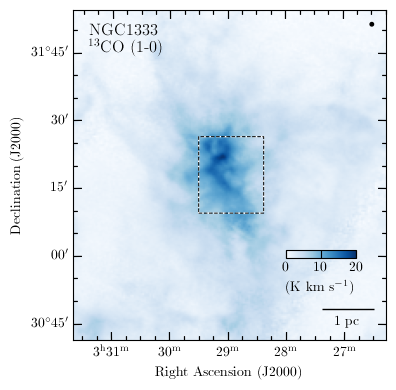

In [5]:
text_color = 'black'

hdu = fits.open(file_TdV_13co)[0]
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Blues').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=0.0, vmax=20.0, cmap=cmap, origin='lower')
ax.invert_xaxis()
ax.invert_yaxis()

plot_setup_ngc1333_wcsaxes(ax, hdu, label_col=text_color, telescope='FCRAO')

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(K km s$^{-1}$)', 
                    orientation='horizontal')
cbar.set_ticks([0, 10, 20])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'$^{13}$CO (1-0)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

plot_footprint(ax, file_list_TdV[1], color='k')
plt.tight_layout()
fig.savefig('figs/NGC1333_13CO_TdV.pdf', dpi=200, bbox_inches='tight')

Set OBSGEO-B to    19.825833 from OBSGEO-[XYZ].
Set OBSGEO-H to       -3.003 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


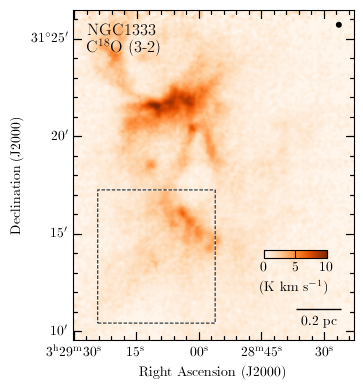

In [6]:
text_color = 'black'

hdu = fits.open(file_TdV_c18o)[0]
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Oranges').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=0.0, vmax=10, cmap=cmap, origin='lower')

plot_setup_ngc1333_wcsaxes(ax, hdu, label_col=text_color, telescope='JCMT')

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(K km s$^{-1}$)', orientation='horizontal')
cbar.set_ticks([0, 5, 10])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'C$^{18}$O (3-2)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plot_footprint(ax, file_list_TdV[2], color='k')
plt.tight_layout()
fig.savefig('figs/NGC1333_C18O_TdV.pdf', dpi=200, bbox_inches='tight')

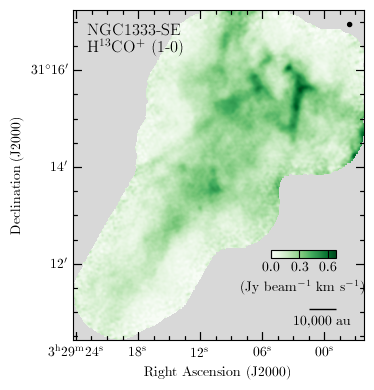

In [7]:
text_color = 'black'

hdu = fits.open(file_TdV_h13cop)[0]
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Greens').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=0.0, cmap=cmap, origin='lower')

plot_setup_ngc1333_wcsaxes(ax, hdu, label_col=text_color, telescope='NOEMA')

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(Jy beam$^{-1}$ km s$^{-1}$)', orientation='horizontal')
cbar.set_ticks([0, 0.3, 0.6])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333-SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'H$^{13}$CO$^+$ (1-0)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
fig.savefig('figs/NGC1333_H13COp_TdV.pdf', dpi=200, bbox_inches='tight')

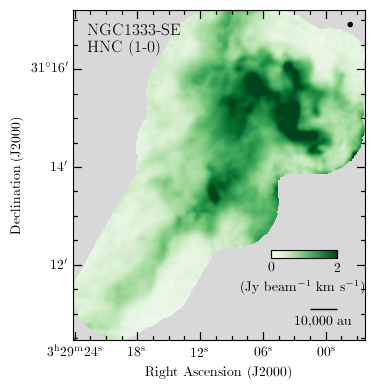

In [8]:
text_color = 'black'

hdu = fits.open(file_TdV_hnc)[0]
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Greens').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=0, vmax=2, cmap=cmap, origin='lower')

plot_setup_ngc1333_wcsaxes(ax, hdu, label_col=text_color, telescope='NOEMA')

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(Jy beam$^{-1}$ km s$^{-1}$)', orientation='horizontal')
# cbar.set_ticks([0, 0.1, 0.2, 0.3])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333-SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'HNC (1-0)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
fig.savefig('figs/NGC1333_HNC_TdV.pdf', dpi=200, bbox_inches='tight')

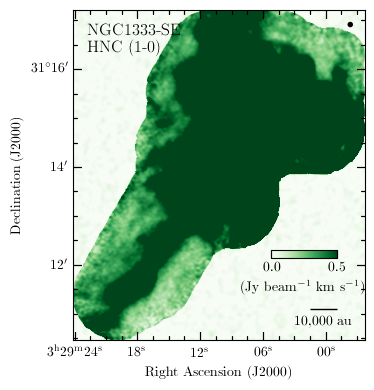

In [9]:
text_color = 'black'

hdu = fits.open(file_TdV_hnc_pad)[0]
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Greens').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=0, vmax=0.5, cmap=cmap, origin='lower')

plot_setup_ngc1333_wcsaxes(ax, hdu, label_col=text_color, telescope='NOEMA')

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(Jy beam$^{-1}$ km s$^{-1}$)', orientation='horizontal')
# cbar.set_ticks([0, 0.1, 0.2, 0.3])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333-SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'HNC (1-0)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
# fig.savefig('figs/NGC1333_HNC_TdV.pdf', dpi=200, bbox_inches='tight')

### Power Spectrum of Intensity

In [10]:
from turbustat.statistics import PowerSpectrum

In [11]:
file_pickle_13co = 'data/powerspec_NGC1333_13CO_1-0_TdV.pickle'
file_pickle_13co_apod = 'data/powerspec_NGC1333_13CO_1-0_TdV_apod.pickle'
file_pickle_c18o = 'data/powerspec_NGC1333_SE_C18O_TdV.pickle'
file_pickle_c18o_apod = 'data/powerspec_NGC1333_SE_C18O-TdV_apod.pickle'
file_pickle_h13cop_pad = 'data/powerspec_NGC1333_H13COp_L17-merged_fix_pad_TdV.pickle'
file_pickle_h13cop = 'data/powerspec_NGC1333_H13COp_L17-merged_fix_TdV.pickle'
file_pickle_hnc_pad = 'data/powerspec_NGC1333_HNC_L23-merged_fix_pad_TdV.pickle'
file_pickle_hnc = 'data/powerspec_NGC1333_HNC_L23-merged_fix_TdV.pickle'

In [12]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
# pspec_13co_TdV
pspec_13co_TdV = pickle.load(open(file_pickle_13co, "rb" ))
pspec_13co_TdV_apod = pickle.load(open(file_pickle_13co_apod, "rb" ))

pspec_c18o_TdV = pickle.load(open(file_pickle_c18o, "rb" ))
pspec_c18o_TdV_apod = pickle.load(open(file_pickle_c18o_apod, "rb" ))

pspec_h13cop_TdV = pickle.load(open(file_pickle_h13cop, "rb" ))
pspec_h13cop_TdV_pad = pickle.load(open(file_pickle_h13cop_pad, "rb" ))

pspec_hnc_TdV = pickle.load(open(file_pickle_hnc, "rb" ))
pspec_hnc_TdV_pad = pickle.load(open(file_pickle_hnc_pad, "rb" ))

### Conversion of pixel units to pc

In [13]:
conv_13co = np.abs((pspec_13co_TdV_apod.header['CDELT1'] * u.deg.to('', equivalencies=u.dimensionless_angles()))*distance).to(u.pc)
conv_c18o = np.abs((pspec_c18o_TdV_apod.header['CDELT1'] * u.deg.to('', equivalencies=u.dimensionless_angles()))*distance).to(u.pc)
conv_h13cop = np.abs((pspec_h13cop_TdV.header['CDELT1'] * u.deg.to('', equivalencies=u.dimensionless_angles()))*distance).to(u.pc)
conv_hnc = np.abs((pspec_hnc_TdV.header['CDELT1'] * u.deg.to('', equivalencies=u.dimensionless_angles()))*distance).to(u.pc)

In [14]:
beam_multiple = 3.0
gd_13co_TdV = (pspec_13co_TdV_apod.freqs.value < np.abs(pspec_13co_TdV_apod.header['CDELT1']) / pspec_13co_TdV_apod.header['BMAJ'] / beam_multiple)
gd_c18o_TdV = (pspec_c18o_TdV_apod.freqs.value < np.abs(pspec_c18o_TdV_apod.header['CDELT1']) / pspec_c18o_TdV_apod.header['BMAJ'] / beam_multiple)

gd_h13cop_TdV = (pspec_h13cop_TdV.freqs.value < np.abs(pspec_h13cop_TdV.header['CDELT1']) / pspec_h13cop_TdV.header['BMAJ'] / beam_multiple)
gd_hnc_TdV = (pspec_hnc_TdV.freqs.value < np.abs(pspec_hnc_TdV.header['CDELT1']) / pspec_hnc_TdV.header['BMAJ'] / beam_multiple)

The goal is to combine the power-spectrum from the different tracers using scaling parameters for $^{13}$CO and  C$^{18}$O, $f_{13}$ and $f_{18}$. The model can be written as:
\begin{equation}
P(k) = A k^{\beta}~,
\end{equation}
where the data for C$^{18}$O is used as anchor.

In [164]:
ln_log = np.log10(np.exp(1))

k_mhd_wave = (1. / 54e-3) # value from Pineda et al. (2023, CRIR)
log_k_mhd_wave = np.log10(k_mhd_wave)

# 13CO 1-0
# linear and log quantities
#
freq_13co_TdV = (pspec_13co_TdV_apod.freqs[gd_13co_TdV] / conv_13co).value
log_freq_13co_TdV = np.log10(freq_13co_TdV)
#
P_TdV_13co = pspec_13co_TdV_apod.ps1D[gd_13co_TdV] * 1e-7
log_P_TdV_13co = np.log10(P_TdV_13co)
eP_TdV_13co = pspec_13co_TdV_apod.ps1D_stddev[gd_13co_TdV] * 1e-7
elogP_TdV_13co = ln_log * eP_TdV_13co / P_TdV_13co


# C18O 3-2
# linear and log quantities
#
freq_c18o_TdV = (pspec_c18o_TdV_apod.freqs[gd_c18o_TdV] / conv_c18o).value
log_freq_c18o_TdV = np.log10(freq_c18o_TdV)
# Normalization for C18O (3-2)
idx = np.abs(log_freq_c18o_TdV - 0.49).argmin()
rescale = pspec_c18o_TdV_apod.ps1D[idx]
#
#
P_TdV_c18o = pspec_c18o_TdV_apod.ps1D[gd_c18o_TdV] / rescale #* 1e-7
#
log_P_TdV_c18o = np.log10(P_TdV_c18o)
eP_TdV_c18o = pspec_c18o_TdV_apod.ps1D_stddev[gd_c18o_TdV] * 1e-7
elogP_TdV_c18o = ln_log * eP_TdV_c18o / P_TdV_c18o

# H13CO+ 1-0
# linear and log quantities
#
freq_h13cop_TdV = (pspec_h13cop_TdV_pad.freqs[gd_h13cop_TdV] / conv_h13cop).value
log_freq_h13cop_TdV = np.log10(freq_h13cop_TdV)
#
P_TdV_h13cop = pspec_h13cop_TdV_pad.ps1D[gd_h13cop_TdV] * 1e-7
log_P_TdV_h13cop = np.log10(P_TdV_h13cop)
eP_TdV_h13cop = pspec_h13cop_TdV_pad.ps1D_stddev[gd_h13cop_TdV] * 1e-7
elogP_TdV_h13cop = ln_log * eP_TdV_h13cop / P_TdV_h13cop


# HNC 1-0
# linear and log quantities
#
freq_hnc_TdV = (pspec_hnc_TdV_pad.freqs[gd_hnc_TdV] / conv_hnc).value
log_freq_hnc_TdV = np.log10(freq_hnc_TdV)
#
P_TdV_hnc = pspec_hnc_TdV_pad.ps1D[gd_hnc_TdV] * 1e-7
log_P_TdV_hnc = np.log10(P_TdV_hnc)
eP_TdV_hnc = pspec_hnc_TdV_pad.ps1D_stddev[gd_hnc_TdV] * 1e-7
elogP_TdV_hnc = ln_log * eP_TdV_hnc / P_TdV_hnc



freq_all_hnc_TdV = np.append(freq_13co_TdV, np.append(freq_c18o_TdV, freq_hnc_TdV))
freq_all_h13cop_TdV = np.append(freq_13co_TdV, np.append(freq_c18o_TdV, freq_h13cop_TdV))

log_freq_all_hnc_TdV = np.append(log_freq_13co_TdV, 
                                 np.append(log_freq_c18o_TdV, log_freq_hnc_TdV))
log_freq_all_h13cop_TdV = np.append(log_freq_13co_TdV, 
                                    np.append(log_freq_c18o_TdV, log_freq_h13cop_TdV))

log_freq_all_hnc_TdV_f = np.append(log_freq_13co_TdV[1:], 
                                 np.append(log_freq_c18o_TdV[1:], log_freq_hnc_TdV[1:]))
log_freq_all_h13cop_TdV_f = np.append(log_freq_13co_TdV[1:], 
                                    np.append(log_freq_c18o_TdV[1:], log_freq_h13cop_TdV[1:]))

#
# Define functions for fitting. 
#
def power_law_spectrum(log_freq, A, beta):
    return A - log_freq * beta

def log_prior_TdV_HNC(theta):
    A, beta, f_13, f_hnc = theta
    if 1.0 < A < 2.5 and 2.0 < beta < 3.4 and 2.0 < f_13 < 3.0 and -2.0 < f_hnc < -1.0:
        return 0.0
    return -np.inf

def log_likelihood_log_TdV_HNC(theta):
    """ Likelihood function for working on log-log"""
    A, beta, f_13, f_hnc = theta
    model_all_hnc = power_law_spectrum(log_freq_all_hnc_TdV_f, A, beta)
    log_P_TdV_all_hnc = np.append(f_13 + log_P_TdV_13co[1:], 
                                  np.append(log_P_TdV_c18o[1:], 
                                            f_hnc + log_P_TdV_hnc[1:])
                                 )
    sigma_all_hnc = np.append(elogP_TdV_13co[1:], 
                              np.append(elogP_TdV_c18o[1:], elogP_TdV_hnc[1:])
                             )
    return -0.5 * np.sum((log_P_TdV_all_hnc - model_all_hnc)**2 / sigma_all_hnc**2)

def log_probability_log_TdV_HNC(theta):
    lp = log_prior_TdV_HNC(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_log_TdV_HNC(theta)


def log_prior_TdV_H13COp(theta):
    A, beta, f_13, f_h13cop = theta
    if 1.0 < A < 2.5 and 2.40 < beta < 3.4 and 2.0 < f_13 < 3.0 and -1.0 < f_h13cop < 0.5:
        return 0.0
    return -np.inf

def log_likelihood_log_TdV_H13COp(theta):
    A, beta, f_13, f_h13cop = theta
    model_all_h13cop = power_law_spectrum(log_freq_all_h13cop_TdV_f, A, beta)
    log_P_TdV_all_h13cop = np.append(f_13 + log_P_TdV_13co[1:],
                                     np.append(log_P_TdV_c18o[1:], 
                                               f_h13cop + log_P_TdV_h13cop[1:])
                                    )
    sigma_all_h13cop = np.append(elogP_TdV_13co[1:], 
                                 np.append(elogP_TdV_c18o[1:], elogP_TdV_h13cop[1:])
                                )
    return -0.5 * np.sum((log_P_TdV_all_h13cop - model_all_h13cop)**2 / sigma_all_h13cop**2)

def log_probability_log_TdV_H13COp(theta):
    lp = log_prior_TdV_H13COp(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_log_TdV_H13COp(theta)

In [155]:
print('Maximum spatial frequency: {0}'.format(np.max(log_freq_all_hnc_TdV)))

Maximum spatial frequency: 1.65752863187699


In [156]:
nll = lambda *args: -log_likelihood_log_TdV_HNC(*args)
initial = np.array([1.4, 3.0, 2.5, -1.5])
soln_log_hnc = minimize(nll, initial)
print(soln_log_hnc.x)

[ 1.4105365   2.91098216  2.49707564 -1.48312677]


In [157]:
nll = lambda *args: -log_likelihood_log_TdV_H13COp(*args)
initial = np.array([1.4, 3.0, 2.5, -0.2])
soln_log_h13cop = minimize(nll, initial)
print(soln_log_h13cop.x)

[ 1.38647345  2.88174289  2.48117321 -0.2413822 ]


## Combine different datasets for plotting

In [158]:
def plot_powerspectrum(ax, solution, 
                       do_hnc=True, label_power_fit=None, 
                       plot_gray=False):
    """
    """
    A = solution[0]
    beta = solution[1]
    f_data1 = solution[2]
    f_data3 = solution[3]

    if label_power_fit == None:
        label_power_fit = r'$\propto k^{'
        label_power_fit = label_power_fit + '{0}'.format(np.round(beta, decimals=2)) + '}$'
    
    label_1 = r'$^{13}$CO'
    label_2 = r'C$^{18}$O'
    
    text_pspec = 'Intensity Power Spectrum'
    #
    log_x_data1 = log_freq_13co_TdV
    log_y_data1 = f_data1 + log_P_TdV_13co
    elog_y_data1 = elogP_TdV_13co
    #
    log_x_data2 = log_freq_c18o_TdV
    log_y_data2 = log_P_TdV_c18o
    elog_y_data2 = elogP_TdV_c18o
    if do_hnc:
        log_x_data3 = log_freq_hnc_TdV
        log_y_data3 = f_data3 + log_P_TdV_hnc
        elog_y_data3 = elogP_TdV_hnc
        label_3 = r'HNC'
    else:
        log_x_data3 = log_freq_h13cop_TdV
        log_y_data3 = f_data3 + log_P_TdV_h13cop
        elog_y_data3 = elogP_TdV_h13cop
        label_3 = r'H$^{13}$CO$^+$'
    
    text_pspec = 'Intensity Power Spectrum (Beam Corrected)'

    if plot_gray:
        ax.errorbar(log_x_data1, log_y_data1, yerr=elog_y_data1, 
                    alpha=0.5, markeredgecolor='k', fmt="o", 
                    ecolor='gray', markerfacecolor='gray')
        ax.errorbar(log_x_data2, log_y_data2, yerr=elog_y_data2, 
                    alpha=0.5, markeredgecolor='k', fmt="o",
                    ecolor='gray', markerfacecolor='gray')
        ax.errorbar(log_x_data3, log_y_data3, yerr=elog_y_data3, 
                    alpha=0.5, markeredgecolor='k', fmt="o",
                    ecolor='gray', markerfacecolor='gray')
    else:
        ax.errorbar(log_x_data1, log_y_data1, yerr=elog_y_data1, 
                alpha=0.5, markeredgecolor='k', label=label_1, fmt="o")
        ax.errorbar(log_x_data2, log_y_data2, yerr=elog_y_data2, 
                alpha=0.5, markeredgecolor='k', label=label_2, fmt="o")
        ax.errorbar(log_x_data3, log_y_data3, yerr=elog_y_data3, 
                alpha=0.5, markeredgecolor='k', label=label_3, fmt="o")
        plt.legend(frameon=False)

    x_sample = np.log10(np.array([0.3, 50]))
    ax.plot(x_sample, power_law_spectrum(x_sample, A, beta), color='w', lw=3, ls=':', zorder=20)
    ax.plot(x_sample, power_law_spectrum(x_sample, A, beta), color='k', lw=2, ls=':', zorder=21)

    
    ax.set_xlabel(r'log (Spatial Frequency) (pc$^{-1}$)')
    ax.set_ylabel(r'log ($P_2(k)$), Arbitrary Units')
 
    ax.text(0.1, power_law_spectrum(-0.1, A, beta) + 0.4, label_power_fit, horizontalalignment='center')

    y_k_mhd = power_law_spectrum(log_k_mhd_wave, A, beta)
    ax.plot([log_k_mhd_wave, log_k_mhd_wave], y_k_mhd + np.array([-1, 1]), color='gray')
    ax.text(log_k_mhd_wave, y_k_mhd + 1.5, '54 mpc', horizontalalignment='center')

    ax.set_xlim(-1, 2)
    plt.tight_layout()
    return

### Intensity Power Spectrum

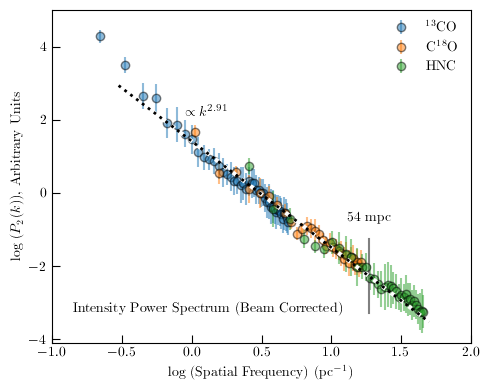

In [159]:
fig, ax = plt.subplots(figsize=(5, 4))
plot_powerspectrum(ax, soln_log_hnc.x, do_hnc=True)

text_pspec = 'Intensity Power Spectrum (Beam Corrected)'
ax.text(0.05, 0.09, text_pspec, horizontalalignment='left', transform=ax.transAxes)
ax.set_ylim(-4.1, 5)

fig.savefig('figs/NGC1333_Intensity_Power_Spectrum_Arb_fit_HNC_log.pdf', bbox_inches='tight')

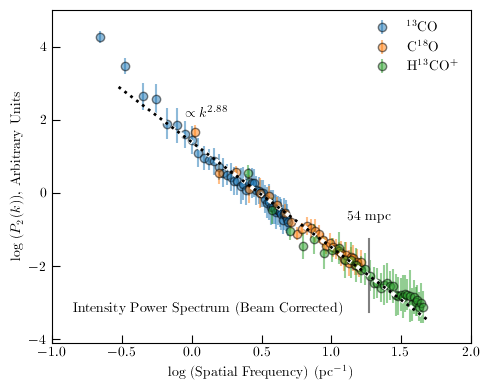

In [160]:
fig, ax = plt.subplots(figsize=(5, 4))
plot_powerspectrum(ax, soln_log_h13cop.x, do_hnc=False)

text_pspec = 'Intensity Power Spectrum (Beam Corrected)'
ax.text(0.05, 0.09, text_pspec, horizontalalignment='left', transform=ax.transAxes)
ax.set_ylim(-4.1, 5)

fig.savefig('figs/NGC1333_Intensity_Power_Spectrum_Arb_fit_H13COp_log.pdf', bbox_inches='tight')

#### Add comparison between Ions and Neutrals at the smallest scales

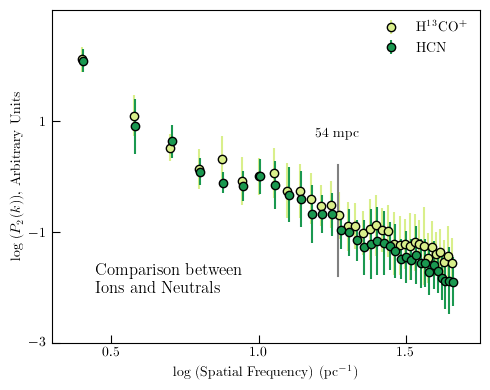

In [147]:
fig, ax = plt.subplots(figsize=(5, 4))

# Normalisation of the power spectra
idx = np.abs(log_freq_h13cop_TdV - 1).argmin()
rescale_ion = log_P_TdV_h13cop[idx]

idx = np.abs(log_freq_hnc_TdV - 1).argmin()
rescale_neutral = log_P_TdV_hnc[idx]

color_HCOp = '#d9ef8b'
color_HNC = '#1a9850'

ax.errorbar(log_freq_h13cop_TdV, log_P_TdV_h13cop - rescale_ion, yerr=elogP_TdV_h13cop, 
            markeredgecolor='k', label='H$^{13}$CO$^+$', fmt="o", 
            ecolor=color_HCOp, markerfacecolor=color_HCOp)
ax.errorbar(log_freq_hnc_TdV, log_P_TdV_hnc - rescale_neutral, yerr=elogP_TdV_hnc, 
            markeredgecolor='k', label='HCN', fmt="o", 
            ecolor=color_HNC, markerfacecolor=color_HNC)

y_k_mhd = -0.8
ax.plot([log_k_mhd_wave, log_k_mhd_wave], y_k_mhd + np.array([-1, 1]), color='gray')
ax.text(log_k_mhd_wave, y_k_mhd + 1.5, '54 mpc', horizontalalignment='center')

plt.legend(frameon=False)

text_pspec = 'Comparison between\n Ions and Neutrals'
ax.text(0.1, 0.15, text_pspec, horizontalalignment='left', transform=ax.transAxes, size=12)

ax.set_xlabel(r'log (Spatial Frequency) (pc$^{-1}$)')
ax.set_ylabel(r'log ($P_2(k)$), Arbitrary Units')
ax.set_xlim(0.3, 1.75)
ax.set_ylim(-3, 3)

ax.xaxis.set_ticks(np.arange(0.5, 1.8, 0.5))
ax.yaxis.set_ticks(np.arange(-3, 3, 2))

plt.tight_layout()

fig.savefig('figs/NGC1333_Intensity_Power_Spectrum_Arb_compare_Ion_Neutral.pdf', bbox_inches='tight')

## EMCEE power-law fit
### Intensity for H$^{13}$CO$^+$

In [165]:
import emcee
import corner
from IPython.display import display, Math

pos = soln_log_h13cop.x + 1e-4 * np.random.randn(32, np.size(soln_log_h13cop.x))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability_log_TdV_H13COp#, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 50000, progress=True);

100%|██████████████████████████████████████████████████████████| 50000/50000 [00:50<00:00, 991.97it/s]


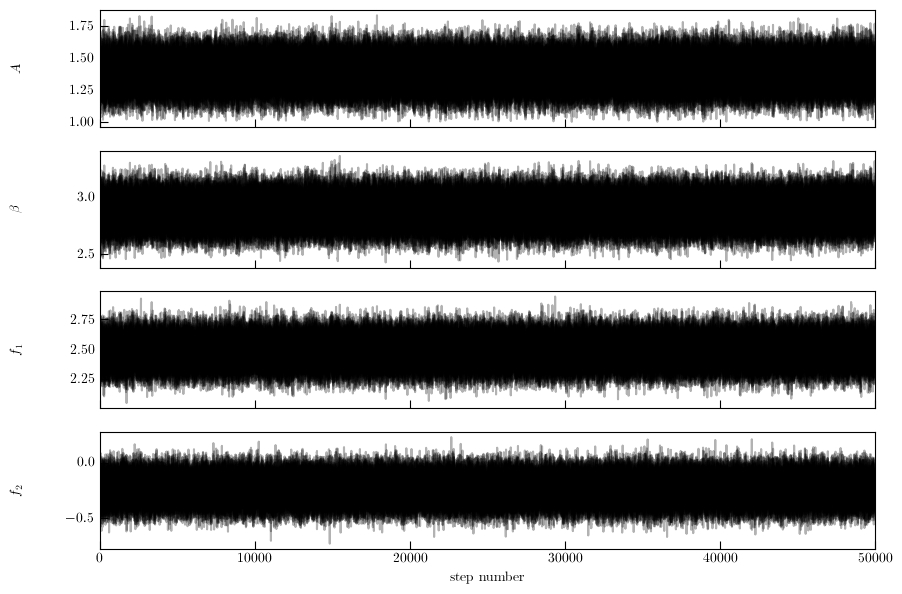

In [166]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$A$", r"$\beta$", r"$f_1$", r"$f_2$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [167]:
tau = sampler.get_autocorr_time()
print(tau)
flat_samples = sampler.get_chain(discard=300, thin=25, flat=True)

[48.61783059 48.2782899  49.56159749 47.88719568]


'\\mathrm{$A$} = 1.39_{-0.10}^{0.10}'

'\\mathrm{$\\beta$} = 2.88_{-0.11}^{0.11}'

'\\mathrm{$f_1$} = 2.48_{-0.09}^{0.09}'

'\\mathrm{$f_2$} = -0.24_{-0.10}^{0.10}'

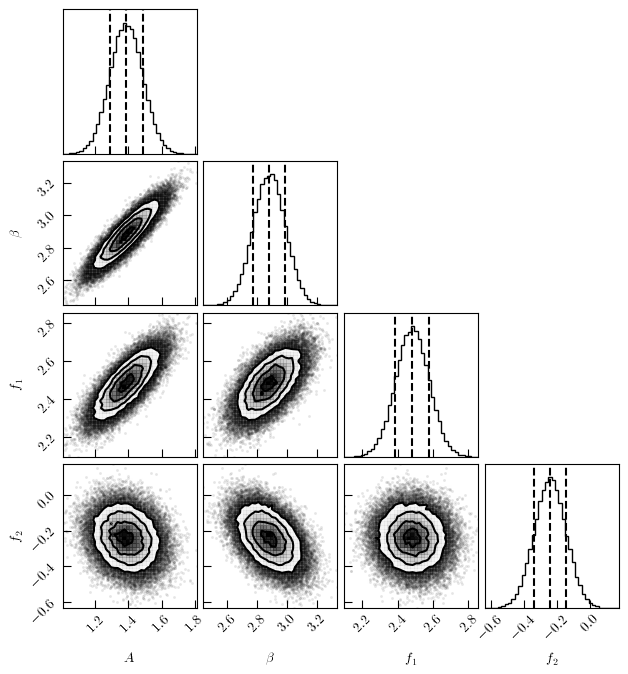

In [168]:
fig_my = plt.figure(figsize=(6.5, 7))

fig = corner.corner(
    flat_samples, 
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=False,
    bins=40, fig=fig_my, color='k')

soln_log_h13cop_EMCEE = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.2f}_{{-{1:.2f}}}^{{{2:.2f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display((txt))
    soln_log_h13cop_EMCEE.append(mcmc[1])
    if i == 1:
        label_beta = r'$\propto k^{'
        label_beta = label_beta + '{0:.2f}_{{-{1:.2f}}}^{{{2:.2f}}}'.format(mcmc[1], q[0], q[1]) + '}$'

fig.savefig('figs/EMCEE_corner_H13CO+.pdf')

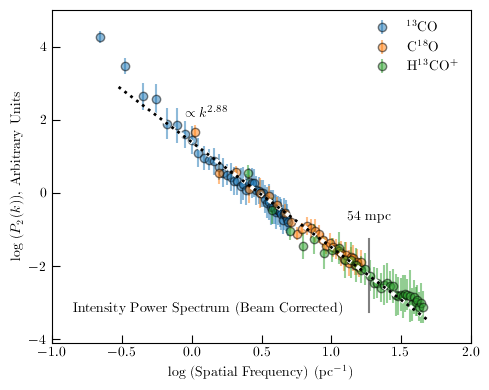

In [169]:
fig, ax = plt.subplots(figsize=(5, 4))
plot_powerspectrum(ax, soln_log_h13cop_EMCEE, do_hnc=False)

ax.set_ylim(-4.1, 5)
text_pspec = 'Intensity Power Spectrum (Beam Corrected)'
ax.text(0.05, 0.09, text_pspec, horizontalalignment='left', transform=ax.transAxes)

fig.savefig('figs/NGC1333_Intensity_Power_Spectrum_Arb_EMCEE_H13COp_log.pdf', bbox_inches='tight')

### Intensity for HNC

In [170]:
import emcee
import corner
from IPython.display import display, Math

pos_log_hnc = soln_log_hnc.x + 1e-4 * np.random.randn(32, np.size(soln_log_hnc.x))
nwalkers_log_hnc, ndim_log_hnc = pos_log_hnc.shape

sampler_log_hnc = emcee.EnsembleSampler(
    nwalkers_log_hnc, ndim_log_hnc, log_probability_log_TdV_HNC
)
sampler_log_hnc.run_mcmc(pos_log_hnc, 50000, progress=True);

100%|██████████████████████████████████████████████████████████| 50000/50000 [00:52<00:00, 946.40it/s]


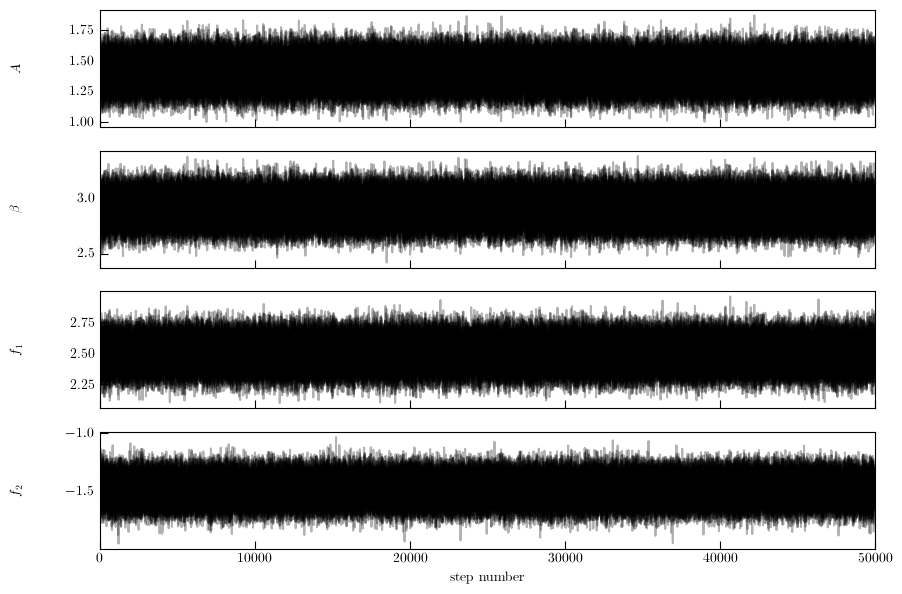

In [171]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples_log_hnc = sampler_log_hnc.get_chain()
labels = [r"$A$", r"$\beta$", r"$f_1$", r"$f_2$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_log_hnc[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_log_hnc))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [172]:
tau_log_hnc = sampler_log_hnc.get_autocorr_time()
print(tau_log_hnc)
flat_samples_log_hnc = sampler_log_hnc.get_chain(discard=300, thin=25, flat=True)

[48.25958048 48.39262167 47.49618923 50.01907571]


'\\mathrm{$A$} = 1.41_{-0.10}^{0.10}'

'\\mathrm{$\\beta$} = 2.91_{-0.11}^{0.11}'

'\\mathrm{$f_1$} = 2.50_{-0.09}^{0.09}'

'\\mathrm{$f_2$} = -1.48_{-0.09}^{0.09}'

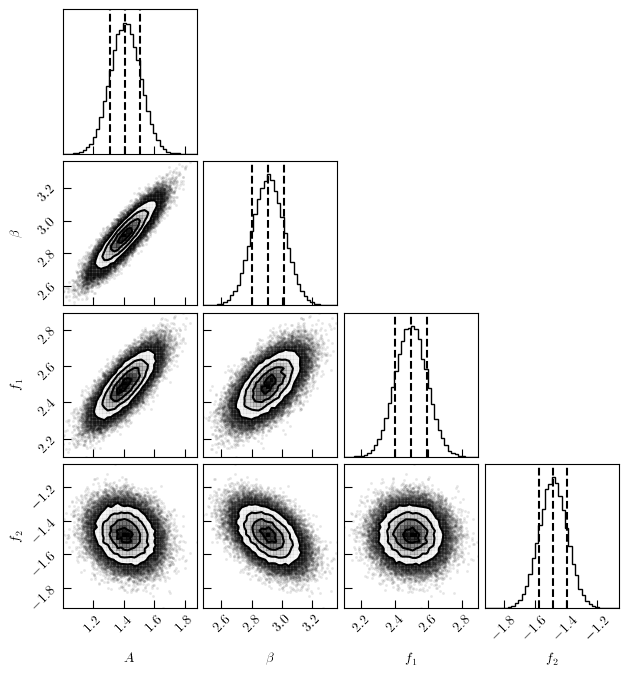

In [173]:
fig_my = plt.figure(figsize=(6.5, 7))

fig = corner.corner(
    flat_samples_log_hnc, 
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=False,
    bins=40, fig=fig_my, color='k')

soln_log_hnc_EMCEE = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples_log_hnc[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.2f}_{{-{1:.2f}}}^{{{2:.2f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display((txt))
    soln_log_hnc_EMCEE.append(mcmc[1])
    if i == 1:
        label_beta = r'$\propto k^{'
        label_beta = label_beta + '{0:.2f}_{{-{1:.2f}}}^{{{2:.2f}}}'.format(mcmc[1], q[0], q[1]) + '}$'

fig.savefig('figs/EMCEE_corner_HNC.pdf')

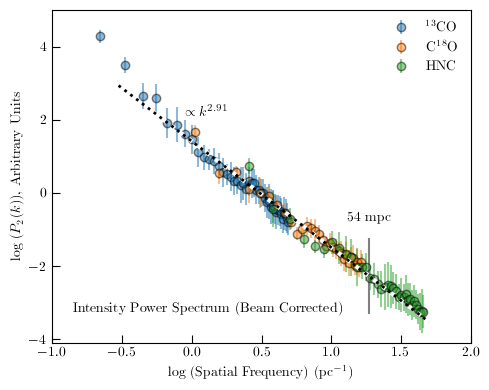

In [174]:
fig, ax = plt.subplots(figsize=(5, 4))
plot_powerspectrum(ax, soln_log_hnc_EMCEE, do_hnc=True)

ax.set_ylim(-4.1, 5)
text_pspec = 'Intensity Power Spectrum (Beam Corrected)'
ax.text(0.05, 0.09, text_pspec, horizontalalignment='left', transform=ax.transAxes)

fig.savefig('figs/NGC1333_Intensity_Power_Spectrum_Arb_EMCEE_HNC_log.pdf', bbox_inches='tight')

Now we export the LaTeX table with the summary of the fits.

In [175]:

soln_log_hnc_EMCEE = []
soln_log_h13cop_EMCEE = []

print("\\begin{tabular}{lcc}")
print("\\hline \hline")
print("Parameter & \ce{H^{13}CO+} & \ce{HNC} \\\\")
print("\\hline")
for i in range(ndim):
    # Create percentiles
    mcmc_h13cop = np.percentile(flat_samples[:, i], [16, 50, 84])
    q_h13cop = np.diff(mcmc_h13cop)

    mcmc_hnc = np.percentile(flat_samples_log_hnc[:, i], [16, 50, 84])
    q_hnc = np.diff(mcmc_hnc)
    
    txt = "{{{3}}} & ${0:.2f}_{{-{1:.2f}}}^{{{2:.2f}}}$"
    txt_2 = "${0:.2f}_{{-{1:.2f}}}^{{{2:.2f}}}$"
    
    txt_h13cop = txt.format(mcmc_h13cop[1], q_h13cop[0], q_h13cop[1], labels[i])
    txt_hnc = txt_2.format(mcmc_hnc[1], q_hnc[0], q_hnc[1])
    
    print(txt_h13cop + ' & ' + txt_hnc + '\\\\')
print("\\hline")
print("\\end{tabular}")

\begin{tabular}{lcc}
\hline \hline
Parameter & \ce{H^{13}CO+} & \ce{HNC} \\
\hline
{$A$} & $1.39_{-0.10}^{0.10}$ & $1.41_{-0.10}^{0.10}$\\
{$\beta$} & $2.88_{-0.11}^{0.11}$ & $2.91_{-0.11}^{0.11}$\\
{$f_1$} & $2.48_{-0.09}^{0.09}$ & $2.50_{-0.09}^{0.09}$\\
{$f_2$} & $-0.24_{-0.10}^{0.10}$ & $-1.48_{-0.09}^{0.09}$\\
\hline
\end{tabular}


## Simulations
Now we try to work with the synthetic $^{13}$CO observations from the simulations from Duo.

In [35]:
from glob import glob
turb_folder = '/Users/jpineda/Dropbox/synthetic_CO_data/turb_box/13CO/'
outflow_folder = '/Users/jpineda/Dropbox/synthetic_CO_data/outflow_data/'
outflow_folder_new = '/Users/jpineda/Dropbox/synthetic_CO_data/20230925_outflow_64/'
turb_stella_new = '/Users/jpineda/Dropbox/synthetic_CO_data/offner_PC/'

In [36]:
file_list_sim = glob(turb_folder + '*.fits')
file_list_sim_t1 = glob(turb_folder + '*turb1*.fits')
file_list_sim_t2 = glob(turb_folder + '*turb2*.fits')
file_list_sim_t3 = glob(turb_folder + '*turb3*.fits')
file_list_sim_t4 = glob(turb_folder + '*turb4*.fits')
file_list_sim_t6 = glob(turb_folder + '*turb6*.fits')

In [37]:
import warnings
from spectral_cube import SpectralCube

def get_power_sim(file_in):
    """
    It reads a sinthetic cube, create an integrated intensity map, and 
    then calculate the power spectrum. It returns the log_freq, log_power
    """
    
    conv_13co_sim = 2. / 64.
    
    cube, header_sim = fits.getdata(file_in, header=True)
    #
    hdu_tmp = fits.open(file_in)[0]
    hdu_tmp.header['CTYPE3'] = 'VRAD'
    hdu_tmp.header['BMAJ'] = hdu_tmp.header['CDELT2']
    hdu_tmp.header['BMIN'] = hdu_tmp.header['CDELT2']
    hdu_tmp.header['BPA'] = 0
    
    cube = SpectralCube.read(hdu_tmp)
    TdV_sim_2 = cube.moment0()
    
    pspec_13co_TdV_sim = PowerSpectrum(TdV_sim_2.hdu, distance=distance)

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')#, 'RuntimeWarning')
        pspec_13co_TdV_sim.run(verbose=False, xunit=u.pc**-1, beam_correct=False)
    
    freq_13co_TdV_sim = (pspec_13co_TdV_sim.freqs / conv_13co_sim).value
    log_freq_13co_TdV_sim = np.log10(freq_13co_TdV_sim)
    P_TdV_13co_sim = pspec_13co_TdV_sim.ps1D 
    eP_TdV_13co_sim = pspec_13co_TdV_sim.ps1D_stddev
    
    idx = np.abs(log_freq_13co_TdV_sim - 0.5).argmin()
    rescale = P_TdV_13co_sim[idx]

    
    P_TdV_13co_sim /= rescale
    eP_TdV_13co_sim /= rescale
    log_P_TdV_13co_sim = np.log10(P_TdV_13co_sim)
    elogP_TdV_13co_sim = ln_log * eP_TdV_13co_sim / P_TdV_13co_sim
    
    return log_freq_13co_TdV_sim, log_P_TdV_13co_sim, elogP_TdV_13co_sim, TdV_sim_2.data



def get_power_soffner(file_in):
    """
    It reads a sinthetic cube, create an integrated intensity map, and 
    then calculate the power spectrum. It returns the log_freq, log_power
    """
    
    cube, header_sim = fits.getdata(file_in, header=True)
    # conv_13co_sim = 2. / 64.
    conv_13co_sim = np.abs((header_sim['CDELT1'] * u.deg.to('', equivalencies=u.dimensionless_angles()))*250*u.pc).to(u.pc)
    
    #
    hdu_tmp = fits.open(file_in)[0]
    hdu_tmp.header['CTYPE3'] = 'VRAD'
    
    cube = SpectralCube.read(hdu_tmp)
    TdV_sim_2 = cube.moment0()
    
    pspec_13co_TdV_sim = PowerSpectrum(TdV_sim_2.hdu, distance=250*u.pc)

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')#, 'RuntimeWarning')
        pspec_13co_TdV_sim.run(verbose=False, xunit=u.pc**-1, beam_correct=False,
                              apodize_kernel='cosinebell', alpha=0.98)
    
    freq_13co_TdV_sim = (pspec_13co_TdV_sim.freqs / conv_13co_sim).value
    log_freq_13co_TdV_sim = np.log10(freq_13co_TdV_sim)
    P_TdV_13co_sim = pspec_13co_TdV_sim.ps1D 
    eP_TdV_13co_sim = pspec_13co_TdV_sim.ps1D_stddev
    
    idx = np.abs(log_freq_13co_TdV_sim - 0.5).argmin()
    rescale = P_TdV_13co_sim[idx]
    
    P_TdV_13co_sim /= rescale
    eP_TdV_13co_sim /= rescale
    log_P_TdV_13co_sim = np.log10(P_TdV_13co_sim)
    elogP_TdV_13co_sim = ln_log * eP_TdV_13co_sim / P_TdV_13co_sim
    
    return log_freq_13co_TdV_sim, log_P_TdV_13co_sim, elogP_TdV_13co_sim, TdV_sim_2.data


def get_power_outflow(cube, verbose=True):
    from turbustat.io.sim_tools import create_fits_hdu
    #
    conv_13co_sim = 2. / 64.
    pixel_scale = conv_13co_sim * u.pc.to(u.au) / 300. * u.arcsec
    #
    spec_pixel_scale = 100. * u.m / u.s
    beamfwhm = 2 * pixel_scale
    imshape = cube.shape
    restfreq = 110.0 * u.GHz
    bunit = u.K
    cube_hdu = create_fits_hdu(cube, pixel_scale, spec_pixel_scale, beamfwhm, imshape, restfreq, bunit)

    cube = SpectralCube.read(cube_hdu)
    TdV_sim_2 = cube.moment0()
    
    pspec_13co_TdV_sim = PowerSpectrum(TdV_sim_2.hdu, distance=distance)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')#, 'RuntimeWarning')
        pspec_13co_TdV_sim.run(xunit=u.pc**-1, beam_correct=False, verbose=verbose, 
                               apodize_kernel='cosinebell', alpha=0.98)
    
    freq_13co_TdV_sim = (pspec_13co_TdV_sim.freqs / conv_13co_sim).value
    log_freq_13co_TdV_sim = np.log10(freq_13co_TdV_sim)
    P_TdV_13co_sim = pspec_13co_TdV_sim.ps1D 
    eP_TdV_13co_sim = pspec_13co_TdV_sim.ps1D_stddev #* 4e-5

    idx = np.abs(log_freq_13co_TdV_sim - 0.5).argmin()
    rescale = P_TdV_13co_sim[idx]
    
    P_TdV_13co_sim /= rescale
    eP_TdV_13co_sim /= rescale
    log_P_TdV_13co_sim = np.log10(P_TdV_13co_sim)
    elogP_TdV_13co_sim = ln_log * eP_TdV_13co_sim / P_TdV_13co_sim
    
    return log_freq_13co_TdV_sim, log_P_TdV_13co_sim, elogP_TdV_13co_sim, TdV_sim_2.data


def get_power_outflow_new(cube, verbose=True):
    from turbustat.io.sim_tools import create_fits_hdu
    #
    conv_13co_sim = 2. / 64.
    pixel_scale = 5 * u.pc.to(u.au) / 300. * u.arcsec
    #
    spec_pixel_scale = 100. * u.m / u.s
    beamfwhm = 2 * pixel_scale
    imshape = cube.shape
    restfreq = 110.0 * u.GHz
    bunit = u.K
    cube_hdu = create_fits_hdu(cube, pixel_scale, spec_pixel_scale, beamfwhm, imshape, restfreq, bunit)

    cube = SpectralCube.read(cube_hdu)
    TdV_sim_2 = cube.moment0()
    
    pspec_13co_TdV_sim = PowerSpectrum(TdV_sim_2.hdu, distance=distance)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')#, 'RuntimeWarning')
        pspec_13co_TdV_sim.run(xunit=u.pc**-1, beam_correct=False, verbose=verbose,
                              apodize_kernel='cosinebell', alpha=0.98)
    
    freq_13co_TdV_sim = (pspec_13co_TdV_sim.freqs / conv_13co_sim).value
    log_freq_13co_TdV_sim = np.log10(freq_13co_TdV_sim)
    P_TdV_13co_sim = pspec_13co_TdV_sim.ps1D 
    eP_TdV_13co_sim = pspec_13co_TdV_sim.ps1D_stddev #* 4e-5

    # Normalize the power spectrum with P(f) = 1 at log (f) = 0.5
    idx = np.abs(log_freq_13co_TdV_sim - 0.5).argmin()
    rescale = P_TdV_13co_sim[idx]
    
    P_TdV_13co_sim /= rescale
    eP_TdV_13co_sim /= rescale
    log_P_TdV_13co_sim = np.log10(P_TdV_13co_sim)
    elogP_TdV_13co_sim = ln_log * eP_TdV_13co_sim / P_TdV_13co_sim
    
    return log_freq_13co_TdV_sim, log_P_TdV_13co_sim, elogP_TdV_13co_sim, TdV_sim_2.data


def mean_simulation(file_list):
    n_files = len(file_list)
    x_dummy, y_dummy, dy_dummy, _ =  get_power_sim(file_list[0])
    x_tile = np.tile(x_dummy, (n_files, 1))
    y_tile = np.tile(y_dummy, (n_files, 1))
    dy_tile = np.tile(dy_dummy, (n_files, 1))
    for i, file_i in enumerate(file_list):
        x_sim_i, y_sim_i, dy_sim_i, _ = get_power_sim(file_i)
        x_tile[i, :] = x_sim_i
        y_tile[i, :] = y_sim_i
        dy_tile[i, :] = dy_sim_i
    x_tile_mean = np.mean(x_tile, axis=0)
    y_tile_mean = np.average(y_tile, axis=0)#, weights=1/dy_tile**2)
    dy_tile_mean = np.std(y_tile, axis=0)
    return x_tile_mean, y_tile_mean, dy_tile_mean

In [41]:
x_sim_t1, y_sim_t1, dy_sim_t1, TdV_t1 = get_power_sim(file_list_sim_t1[0])
x_sim_t2, y_sim_t2, dy_sim_t2, TdV_t2 = get_power_sim(file_list_sim_t2[0])
x_sim_t3, y_sim_t3, dy_sim_t3, TdV_t3 = get_power_sim(file_list_sim_t3[0])
x_sim_t4, y_sim_t4, dy_sim_t4, TdV_t4 = get_power_sim(file_list_sim_t4[0])
x_sim_t6, y_sim_t6, dy_sim_t6, TdV_t6 = get_power_sim(file_list_sim_t6[0])

### Comparison with Power Spectrum of Outflow Synthetic Data

#### Comparison with data from Duo
Here we load all the synthetic $^{13}$CO (1-0) cubes and then calculate the power spectrum of the integrated intensity maps.

In [42]:
# outflow_cube = np.load(outflow_folder + 'data_13co_all.npy')
# shape_outflow = outflow_cube.shape

In [43]:
# x_dummy, y_dummy, dy_dummy, _ =  get_power_outflow(outflow_cube[0,:,:,:])

# x_tile = np.tile(x_dummy, (shape_outflow[0], 1))
# y_tile = np.tile(y_dummy, (shape_outflow[0], 1))
# dy_tile = np.tile(dy_dummy, (shape_outflow[0], 1))

# for i in range(shape_outflow[0]):
#     x_sim_i, y_sim_i, dy_sim_i, _ =  get_power_outflow(outflow_cube[i,:,:,:], verbose=False)
#     x_tile[i, :] = x_sim_i
#     y_tile[i, :] = y_sim_i
#     dy_tile[i, :] = dy_sim_i

In [44]:
# x_tile_mean = np.mean(x_tile, axis=0)
# y_tile_mean = np.average(y_tile, axis=0)#, weights=1/dy_tile**2)
# dy_tile_mean = np.std(y_tile, axis=0)

In [45]:
# plt.imshow(y_tile)

In [46]:
# plt.imshow(dy_tile)

In [47]:
# cube, hd = fits.getdata(turb_stella_new + 'conv_330_cloud_13co.fits', header=True)

In [48]:
x_soffner_13co, y_soffner_13co, dy_soffner_13co, TdV_soffner_13co = get_power_soffner(turb_stella_new + 'conv_330_cloud_13co.fits')

In [49]:
x_soffner_c18o, y_soffner_c18o, dy_soffner_c18o, TdV_soffner_c18o = get_power_soffner(turb_stella_new + 'conv_330_cloud_c18o.fits')

### Comparison with Power Spectrum of Outflow Synthetic Data

In [50]:
# outflow_cube_new = np.load(outflow_folder_new + 'data_12co_64_all.npy')
# shape_outflow_new = outflow_cube_new.shape

In [51]:
# x_dummy, y_dummy, dy_dummy, _ =  get_power_outflow(outflow_cube_new[0,:,:,:])

# x_tile_new = np.tile(x_dummy, (shape_outflow_new[0], 1))
# y_tile_new = np.tile(y_dummy, (shape_outflow_new[0], 1))
# dy_tile_new = np.tile(dy_dummy, (shape_outflow_new[0], 1))

# for i in range(shape_outflow_new[0]):
#     x_sim_i, y_sim_i, dy_sim_i, _ =  get_power_outflow(outflow_cube_new[i,:,:,:], verbose=False)
#     x_tile_new[i, :] = x_sim_i
#     y_tile_new[i, :] = y_sim_i
#     dy_tile_new[i, :] = dy_sim_i

In [53]:
# plt.imshow(y_tile_new)

### Comparison of data and simulations

In [54]:
# # 16  45  168
# index = 263
# x_dummy, y_dummy, dy_dummy, _ =  get_power_outflow(outflow_cube_new[index,:,:,:])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1782.
Date:                Fri, 10 Nov 2023   Prob (F-statistic):           5.53e-95
Time:                        17:34:14   Log-Likelihood:                 54.858
No. Observations:                 181   AIC:                            -105.7
Df Residuals:                     179   BIC:                            -99.32
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1870      0.042    148.900      0.0

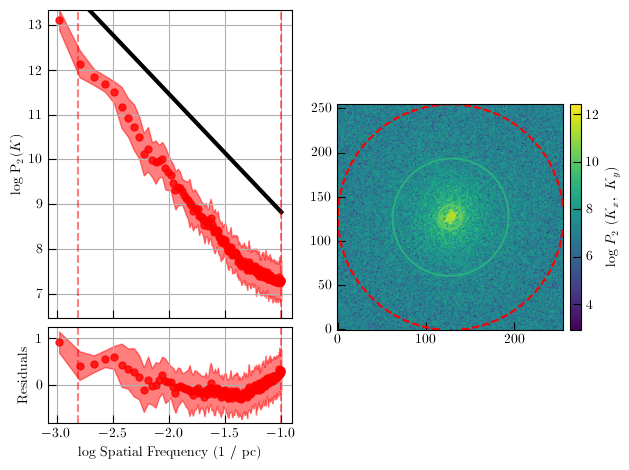

In [55]:
data, hd = fits.getdata('/Users/jpineda/science/NGC1333_NOEMA_turbulence/outflow_data/co12_52r00429t4_x0_255_conv50.fits', header=True)
x_duo_12co, y_duo_12co, dy_duo_12co, TdV_duo_12co = get_power_outflow_new(data)

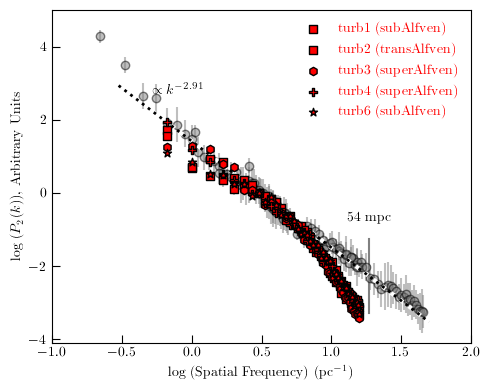

In [95]:
fig, ax = plt.subplots(figsize=(5, 4))

plot_powerspectrum(ax, soln_log_hnc_EMCEE, do_hnc=True, plot_gray=True)

ax.scatter(x_sim_t1, y_sim_t1, label='turb1 (subAlfven)', zorder=40,
            alpha=1, color='k', marker="s", facecolor='red')
ax.scatter(x_sim_t2, y_sim_t2, label='turb2 (transAlfven)',zorder=41,
            alpha=1, color='k', marker="s", facecolor='red')
ax.scatter(x_sim_t3, y_sim_t3, label='turb3 (superAlfven)', zorder=42,
            alpha=1, color='k', marker="h", facecolor='red')
ax.scatter(x_sim_t4, y_sim_t4, label='turb4 (superAlfven)', zorder=43,
            alpha=1, color='k', marker="P", facecolor='red')
ax.scatter(x_sim_t6, y_sim_t6, label='turb6 (subAlfven)',zorder=44,
            alpha=1, color='k', marker="*", facecolor='red')

# plt.legend()
# current_handles, current_labels = plt.gca().get_legend_handles_labels()
# new_handles = list(current_handles[:-3])
# new_labels = list(current_labels[:-3])
plt.legend(labelcolor='linecolor', frameon=False)
ax.set_ylim(-4.1, 5)

fig.savefig('figs/NGC1333_Intensity_Power_Spectrum_Arb_EMCEE_HNC_log_compare_sim_box.pdf', bbox_inches='tight')

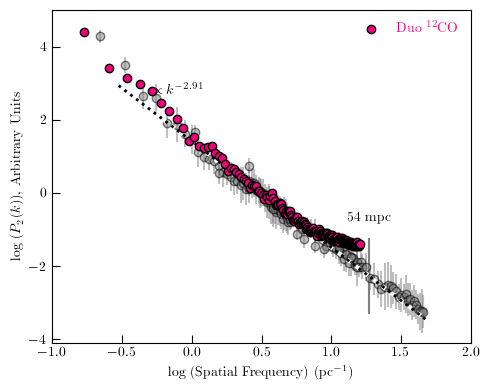

In [96]:
fig, ax = plt.subplots(figsize=(5, 4))

plot_powerspectrum(ax, soln_log_hnc_EMCEE, do_hnc=True, plot_gray=True)

ax.scatter(x_duo_12co, y_duo_12co, marker='o', zorder=42,
            alpha=1, color='k', label=r'Duo $^{12}$CO', facecolor='#f0027f')

# plt.legend()
# current_handles, current_labels = plt.gca().get_legend_handles_labels()
# new_handles = list(current_handles[:-3])
# new_labels = list(current_labels[:-3])
plt.legend(labelcolor='linecolor', frameon=False)
ax.set_ylim(-4.1, 5)

fig.savefig('figs/NGC1333_Intensity_Power_Spectrum_Arb_EMCEE_HNC_log_compare_sim_duo.pdf', bbox_inches='tight')

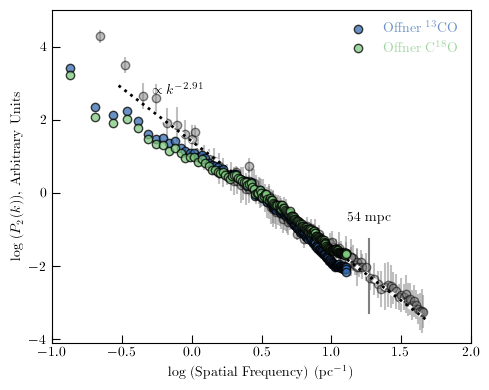

In [92]:
fig, ax = plt.subplots(figsize=(5, 4))

plot_powerspectrum(ax, soln_log_hnc_EMCEE, do_hnc=True, plot_gray=True)

ax.scatter(x_soffner_13co, y_soffner_13co, marker='o', zorder=40,
            alpha=0.75, color='k', label=r'Offner $^{13}$CO', facecolor='#386cb0')
ax.scatter(x_soffner_c18o, y_soffner_c18o, marker='o', zorder=41,
            alpha=0.75, color='k', label=r'Offner C$^{18}$O', facecolor='#7fc97f')


# current_handles, current_labels = plt.gca().get_legend_handles_labels()
# new_handles = list(current_handles[:-3])
# new_labels = list(current_labels[:-3])
# plt.legend(new_handles, new_labels, labelcolor='linecolor', frameon=False)
plt.legend(labelcolor='linecolor', frameon=False)
ax.set_ylim(-4.1, 5)

fig.savefig('figs/NGC1333_Intensity_Power_Spectrum_Arb_EMCEE_HNC_log_compare_sim_Offner.pdf', bbox_inches='tight')

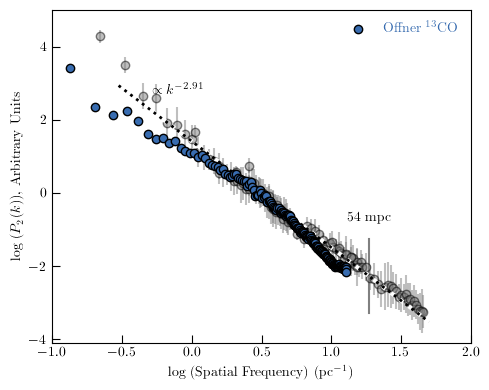

In [90]:
fig, ax = plt.subplots(figsize=(5, 4))

plot_powerspectrum(ax, soln_log_hnc_EMCEE, do_hnc=True, plot_gray=True)

ax.scatter(x_soffner_13co, y_soffner_13co, marker='o', zorder=40,
            color='k', label=r'Offner $^{13}$CO', facecolor='#386cb0')

# current_handles, current_labels = plt.gca().get_legend_handles_labels()
# new_handles = list(current_handles[:-3])
# new_labels = list(current_labels[:-3])
plt.legend(labelcolor='linecolor', frameon=False)
ax.set_ylim(-4.1, 5)

fig.savefig('figs/NGC1333_Intensity_Power_Spectrum_Arb_EMCEE_HNC_log_compare_sim_Offner_13CO.pdf', bbox_inches='tight')

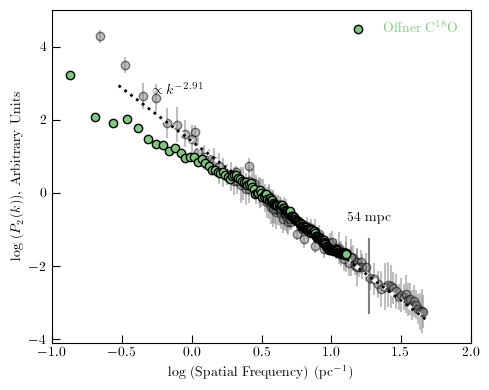

In [91]:
fig, ax = plt.subplots(figsize=(5, 4))

plot_powerspectrum(ax, soln_log_hnc_EMCEE, do_hnc=True, plot_gray=True)

ax.scatter(x_soffner_c18o, y_soffner_c18o, marker='o', zorder=41, 
            color='k', label=r'Offner C$^{18}$O', facecolor='#7fc97f')


# current_handles, current_labels = plt.gca().get_legend_handles_labels()
# new_handles = list(current_handles[:-3])
# new_labels = list(current_labels[:-3])
leg = plt.legend(labelcolor='linecolor', frameon=False)
# for lh in leg.get_texts(): 
#     lh.set_alpha(1)

ax.set_ylim(-4.1, 5)

fig.savefig('figs/NGC1333_Intensity_Power_Spectrum_Arb_EMCEE_HNC_log_compare_sim_Offner_C18O.pdf', bbox_inches='tight')